## Task 0 - Model choice

The tensorflow implementation of keras is used for simplicity. 

I am using transfer learning by using starting weights trained on the imagenet dataset. 
The task has no time contraint on inference/train time.
For these two reasons taking a look at https://paperswithcode.com/sota/image-classification-on-cifar-10 gives a pretty good picture how well a model performs.
However, I can only use 1000 samples for training, which makes it harder to train a model that generalizes well.

I have chosen DenseNet because I have a fair amount of experience with it and it is pretty accurate and stable accross different datasets and tasks.

## Task 1 - Dataset subsampling

The train and test set are sampled from the same underlying data generating process.
Therefore I wouldn't introduce a filtering method at the start of the project. But I prefer to also use the same class distribution in both sets. 
Because of this, I am going to sample the same amount of images from all classes. 

## Task 2 - Extra output

Used Lambda Layer and tf.ones_like to solve this task.

## Task 3 - Training and fine-tuning

Because the classes are evenly distrubuted and we have no real preferance for one over another, accuracy as a metric is adequate.

The have a model with very high capacity (18M parameters) and the cifar images are 32 by 32 pixels large, so fitting the training set is going to be easy. Not overfitting the training data too much is central goal in nearly every machine learining problem, but having only 1000 samples makes it even more important. 
To alleivate the dataset size restriction, I use heavy data augmentation. I have tried a few values for the arguments of ImageDataGenerator. The constants found in the notebook seemed to be best.

As the optimizer, I have tested NAdam, Adam and Ranger. Ranger significantly outperformed the others by around 5 accuracy percent.

1e-4 leaning rate was the best according to my tests. This produced the lowest gaps between training and validation losses during training.
Same goes for the batch size of 16.

### Futher optimization

I would use cross-validation and run a grid search for better hyperparameters. Additionally, I would write a custom data augmenter (using imgaug for example) to increase the types of augmentation techniques (noise, blurring, contrast, etc.) and to test if enabling augmentation later in the training or varying the strength of the augmentation mid-training would improve the accuracy.

I would also try to freeze the first few layers after 2-3 epochs.

Experimenting with other off the shelf models like EfficentNet could also give performance gains.

Testing other cost functions like focal loss seems also promising. But before that I would examine the model's detailed performance on the test set.

## Task 4 Next steps
1. Develop an environment where the experiments can be carried out efficiently and can be reproduced. This includes saving the model, its parameters and the details of the environment the training ran in.

2. Try other off the shelf solutions like EfficientNet or others listed in https://paperswithcode.com/sota/image-classification-on-cifar-10. Use the best for the next steps.

3. Examine the performance on the test set thoroughly. 
    1. Compute precision and recall metric for all classes.
    2. Visually check the misclassified images and also look at the confidence values.
    3. Compute top-k accuracys, also look at the images the model classifies the most or least confidently
    
4. Tinker with the cost function based on step 3. Repeat step 3.

5. Try several learning schedulers like readuce on plateu or cyclic learning rate. Repeat step 3.

6. Implement a more extensive data augmentation solution described in Task 3 under Further optimization. Repeat step 3.

7. Do a grid search for better hyperparameters.

8. If there is still time, read research papers focusing on cifar10 to find techiques to further improve the performance.

## Task 5 

I would use TF Serving for deployment. It only requires to convert the trained model and run a few commands on the host. After that, the model can be used over a Rest API. 



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import cv2
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
# Load the dataset
ds = tfds.load('cifar10', split='train', shuffle_files=True)
ds

<_OptionsDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

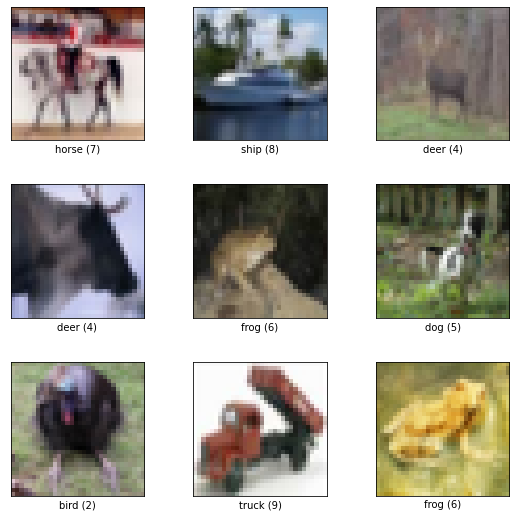

In [3]:
# Look at a few examples
ds, info = tfds.load('cifar10', split='train', with_info=True)
fig = tfds.show_examples(ds, info)

In [4]:
#Load the used dataset and convert it to pandas DataFrame

train_ds, test_ds = tfds.load('cifar10', split=['train[:2000]','test[:10000]'], as_supervised=True)
def ds_to_tabular(ds):
    """Convert a tf.data.Dataset instance to pd.DataFrame with image and label columns"""
    images, labels =  list(zip(*tfds.as_numpy(ds)))
    return pd.DataFrame(data={'image':images,'label':labels})

train_df, test_df = ds_to_tabular(train_ds), ds_to_tabular(test_ds)

In [5]:
# Resize so we can train DenseNet with these images
image_shape = (64,64)
def resize_image_column(df):
    df.image = df.image.apply(lambda x:cv2.resize(x,image_shape))

resize_image_column(train_df)
resize_image_column(test_df)

(array([231., 186., 184., 198., 186., 210., 186., 206., 213., 200.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Train class distribution')

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Test class distribution')

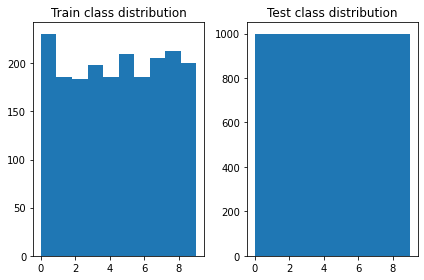

In [6]:
# Class distributions

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()

ax0.hist(train_df.label)
ax0.set_title('Train class distribution')

ax1.hist(test_df.label )
ax1.set_title('Test class distribution')

fig.tight_layout()
plt.show()


,image,label
1659,"[[[78, 139, 205], [78, 139, 205], [78, 140, 20...",0
1624,"[[[151, 203, 235], [148, 201, 233], [143, 197,...",0
1430,"[[[148, 169, 198], [148, 169, 198], [148, 169,...",0
423,"[[[92, 112, 139], [92, 112, 139], [93, 113, 14...",0
1625,"[[[100, 164, 238], [100, 164, 238], [101, 164,...",0
...,...,...
1307,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",9
1062,"[[[144, 181, 218], [146, 181, 219], [149, 182,...",9
1825,"[[[106, 151, 192], [106, 151, 192], [107, 152,...",9
1621,"[[[174, 201, 231], [174, 201, 231], [174, 200,...",9


,image,label
399,"[[[193, 202, 194], [192, 201, 193], [189, 199,...",0
323,"[[[107, 147, 203], [107, 146, 203], [108, 145,...",0
1528,"[[[116, 117, 123], [106, 107, 113], [86, 88, 9...",0
1158,"[[[39, 55, 24], [46, 61, 31], [61, 74, 45], [7...",0
1333,"[[[25, 86, 26], [25, 86, 26], [26, 86, 27], [2...",0
...,...,...
1232,"[[[15, 15, 13], [15, 15, 13], [16, 16, 14], [1...",9
1920,"[[[160, 151, 144], [160, 151, 144], [160, 151,...",9
267,"[[[130, 175, 208], [132, 176, 209], [137, 178,...",9
1078,"[[[237, 237, 237], [236, 236, 236], [233, 233,...",9


<AxesSubplot:>

<AxesSubplot:>

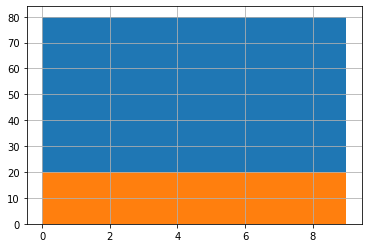

In [7]:
# Split train-validation and sample even sized chunks from every class

num_samples = 1000
num_classes = len(set(train_df.label))
validation_split_ratio = 0.2
train_df = train_df.groupby('label').apply(lambda x:x.sample(int(num_samples//num_classes)))
train_df = train_df.droplevel(level=0)
validation_df = train_df.groupby('label').apply(lambda x:x.sample(int(num_samples//num_classes*validation_split_ratio)))
validation_df = validation_df.droplevel(level=0)
train_df = train_df.drop(index=validation_df.index.values)
train_df
validation_df
train_df.label.hist()
validation_df.label.hist()

In [8]:
# Convert tabular data to numpy arrays

def tabular_to_numpy(df, num_classes=None):
    return np.array(list(df.image)), tf.keras.utils.to_categorical(df.label.to_numpy(),num_classes=num_classes)
train_x, train_y  = tabular_to_numpy(train_df)
validation_x, validation_y  = tabular_to_numpy(validation_df)
test_x, test_y  = tabular_to_numpy(test_df)
train_x.shape,train_y.shape,validation_x.shape,validation_y.shape,test_x.shape,test_y.shape

((800, 64, 64, 3),
 (800, 10),
 (200, 64, 64, 3),
 (200, 10),
 (10000, 64, 64, 3),
 (10000, 10))

In [9]:
# Build the model

feature_extractor = tf.keras.applications.DenseNet201(include_top=False,input_shape=image_shape+(3,),pooling='avg')
model_input = feature_extractor.input
features = feature_extractor(model_input)
flattened_featues = Flatten()(features)
real_output =  Dense(num_classes,activation='softmax',name='out')(flattened_featues)
dummy_output = tf.keras.layers.Lambda(lambda x: tf.ones_like(x),name='dummy_output')(real_output)
model = Model(model_input,[real_output,dummy_output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
out (Dense)                  (None, 10)                19210     
_________________________________________________________________
dummy_output (Lambda)        (None, 10)                0         
Total params: 18,341,194
Trainable params: 18,112,138
Non-trainable params: 229,056
_________________________________________________________________


In [10]:
# Create optimizer and compile the model

radam = tfa.optimizers.RectifiedAdam(lr=1e-4)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(optimizer=ranger, loss={'out':'categorical_crossentropy'}, metrics={'out':'acc'})

In [11]:
# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.10,
    horizontal_flip=True)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
# Train the model

batch_size = 16
epochs = 60
train_history = model.fit(train_datagen.flow(train_x, train_y, batch_size=batch_size),
          validation_data=validation_datagen.flow(validation_x,validation_y,batch_size=batch_size),
          validation_steps=len(validation_x) // batch_size,
          #validation_data=(validation_x,validation_y),
          steps_per_epoch=len(train_x) // batch_size,
          epochs=epochs)

Epoch 1/60
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


50/50 [==============================] - 15s 301ms/step - loss: 2.7884 - out_loss: 2.7884 - out_acc: 0.0938 - val_loss: 3.0242 - val_out_loss: 3.0242 - val_out_acc: 0.1198
Epoch 2/60
50/50 [==============================] - 12s 236ms/step - loss: 2.5895 - out_loss: 2.5895 - out_acc: 0.1462 - val_loss: 2.4510 - val_out_loss: 2.4510 - val_out_acc: 0.1667
Epoch 3/60
50/50 [==============================] - 12s 239ms/step - loss: 2.3521 - out_loss: 2.3521 - out_acc: 0.1887 - val_loss: 2.2086 - val_out_loss: 2.2086 - val_out_acc: 0.2135
Epoch 4/60
50/50 [==============================] - 12s 243ms/step - loss: 2.0832 - out_loss: 2.0832 - out_acc: 0.2763 - val_loss: 2.0285 - val_out_loss: 2.0285 - val_out_acc: 0.2812
Epoch 5/60
50/50 [==============================] - 12s 236ms/step - loss: 1.7971 - out_loss: 1.7971 - out_acc: 0.4000 - val_loss: 1.8095 - val_out_loss: 1.8095 - val_out_acc: 0.3333
Epoch 6/60
50/50 [==============================] - 12s 234ms/step - loss: 1.5872 - out_loss: 1.

Text(0.5, 1.0, 'Training and Validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

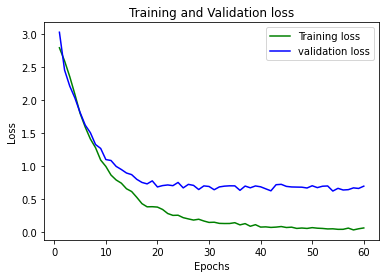

In [24]:
loss_train = train_history.history['loss']
loss_val = train_history.history['val_loss']
epoch_l = range(1,epochs+1)
plt.plot(epoch_l, loss_train, 'g', label='Training loss')
plt.plot(epoch_l, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Training and Validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

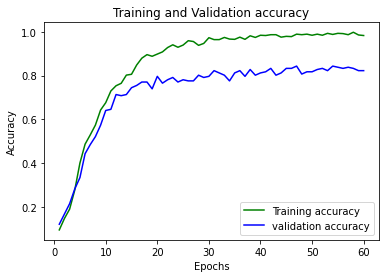

In [25]:
loss_train = train_history.history['out_acc']
loss_val = train_history.history['val_out_acc']
epochs = range(1,epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
#Evaluate on the test set
test_result = model.evaluate(validation_datagen.flow(test_x, test_y, batch_size=batch_size),batch_size=32,steps=len(test_x)//32)

312/312 [==============================] - 7s 24ms/step - loss: 0.7783 - out_loss: 0.7783 - out_acc: 0.7800


## Result on the training set is: 0.7783 categorical crossentropy loss and 78% accuracy

In [14]:
# Assert that the two outputs look correctly formed
model.predict(validation_datagen.flow(test_x, test_y, batch_size=batch_size),batch_size=32,steps=1)

[array([[1.70798937e-03, 1.80162024e-04, 1.42289355e-05, 1.84153242e-03,
         3.49741676e-05, 2.35025445e-03, 3.47528979e-03, 4.30781627e-04,
         7.13063811e-04, 9.89251673e-01],
        [8.48767468e-06, 1.57483228e-04, 8.98292274e-06, 6.38601705e-05,
         1.05773352e-05, 2.83061934e-04, 4.42084565e-05, 1.16828478e-05,
         2.88612173e-05, 9.99382854e-01],
        [2.25887657e-03, 5.07903751e-04, 1.10665061e-01, 8.66834402e-01,
         2.80627253e-04, 1.68782473e-03, 1.48200318e-02, 1.24675897e-03,
         1.68747630e-03, 1.10037581e-05],
        [1.75005402e-02, 7.75077194e-03, 1.92150950e-01, 8.81520275e-04,
         6.47065401e-01, 7.38797418e-04, 1.20769034e-03, 1.29303411e-01,
         2.51259399e-03, 8.88309616e-04],
        [9.21277329e-02, 1.57401413e-02, 1.63489953e-03, 2.32136492e-02,
         8.07873845e-01, 9.17135738e-03, 1.01787411e-02, 4.29322524e-03,
         1.38466787e-02, 2.19197664e-02],
        [2.17310078e-02, 8.59198987e-01, 2.43556011e-03, 7.8